
<h1 align="center"><font color='#4169E1'>AI Camp : </font> <font color='#D23B68'>Image Classification</font></h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# 1. Image Classification Datasets : Examples

<h3><font color='#D23B68'>MNIST</font></h3>

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


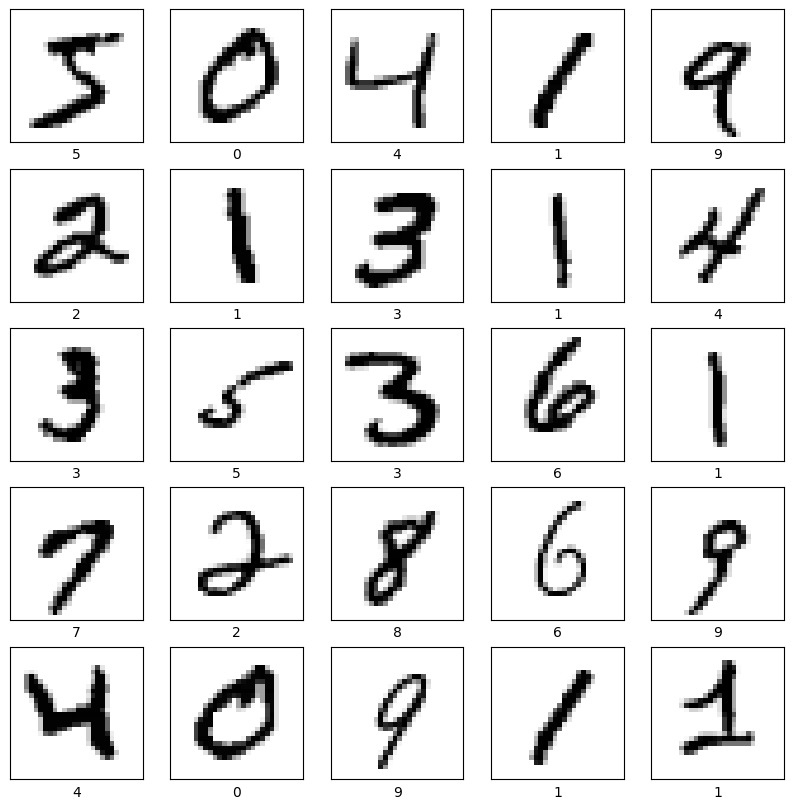

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

<h3><font color='#D23B68'>Fashion MNIST</font></h3>

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
# Define class labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

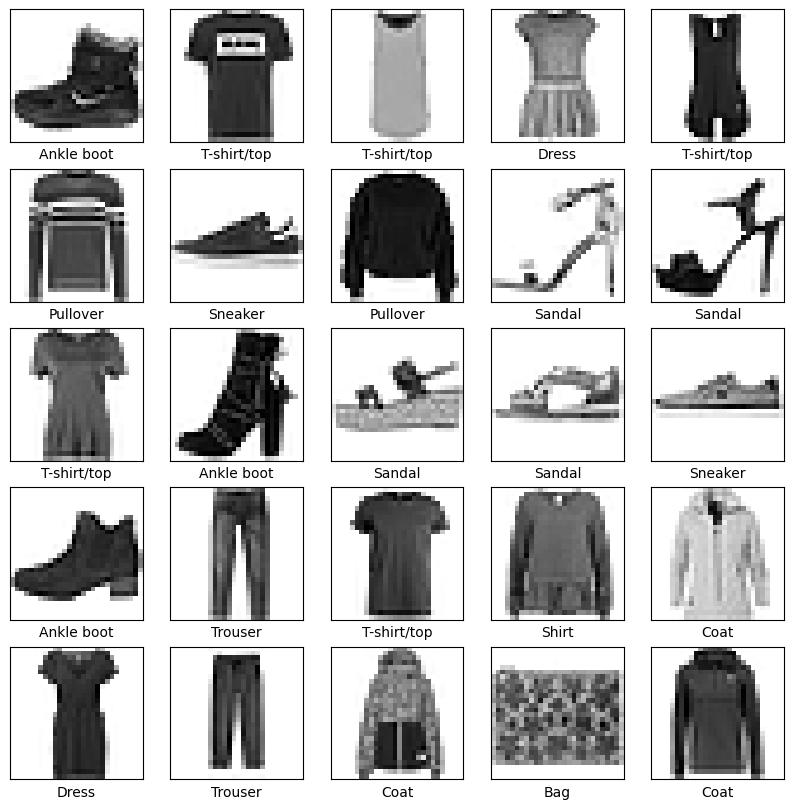

In [6]:
# Visualize some random samples from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

<h3><font color='#D23B68'>CIFAR-10</font></h3>

In [7]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [8]:
# Define class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

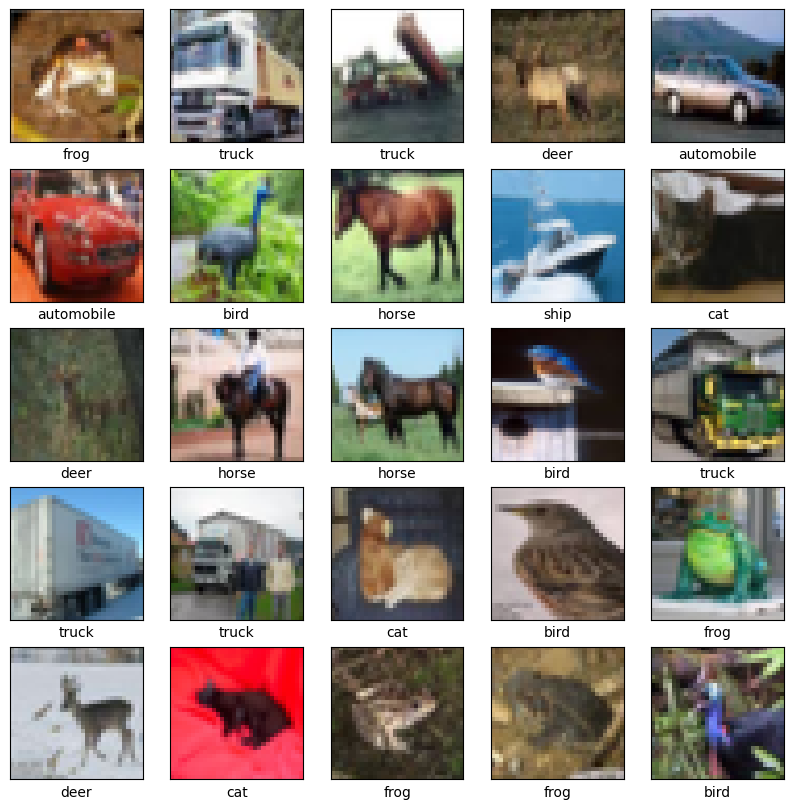

In [9]:
# Visualize some random samples from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# 2. Transfer Learning and Fine-Tuning

Let's see an example !

This is gonna be all about tail-wagging fun 🐶 and whisker-twitching wonder 🐱!

<h3><font color='#D23B68'>Downloading the dataset</font></h3>

In [10]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Load training set
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
# Load validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
# Create a test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


<h3><font color='#D23B68'>Displaying some image examples</font></h3>

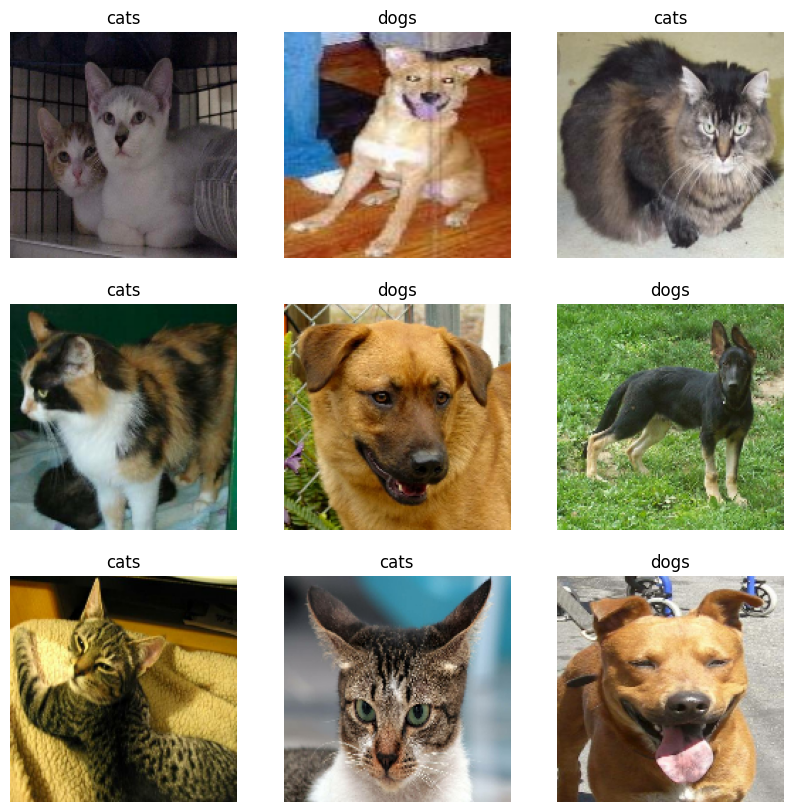

In [11]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

<h3><font color='#D23B68'>Rescaling images to match the model that we'll be using</font></h3>

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<h3><font color='#D23B68'>Applying data augomentation</font></h3>

Our dataset is not that big, so as seen in the previous it's a good practice to use the **Data Augmentation** technique by applying random transformations to the training images, such as rotation and horizontal flipping.

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's take a look !

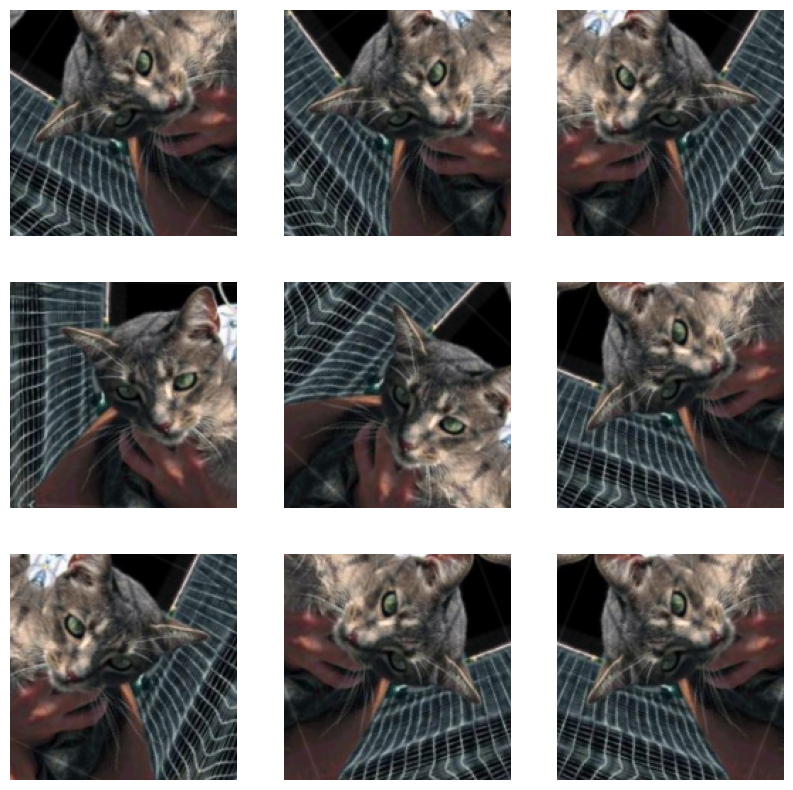

In [14]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

<h3><font color='#D23B68'>Creating the base model that we'll be using for transfer learning</font></h3>

- We will create the base model from the **MobileNet V2** model.
- It is pre-trained on the ImageNet dataset.
- We will use it for our Cats and Dogs dataset to demonstrate both Transfer Learning techniques :)

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape= IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


<h1><font color='#4169E1'>I. Using a pre-trained model for feature extraction</font></h1>

<h3><font color='#D23B68'>Freeze the convolutional base</font></h3>

In [16]:
base_model.trainable = False

Let's take a look !

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

<h3><font color='#D23B68'>Add a classification part</font></h3>

In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

<h3><font color='#D23B68'>Building the final model</font></h3>

We do so by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers.

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

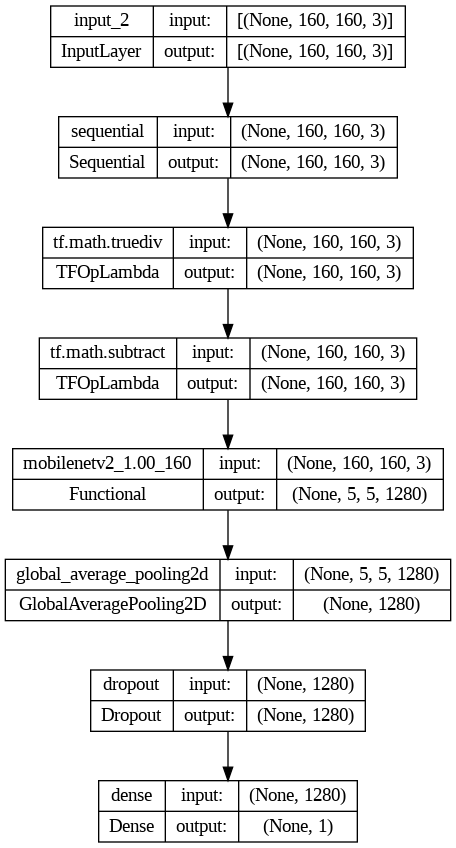

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
# We won't have to train much variables !
len(model.trainable_variables)

2

<h3><font color='#D23B68'>Compile the model</font></h3>

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

<h3><font color='#D23B68'>Train the model</font></h3>

In [25]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 55ms/step - loss: 0.7010 - accuracy: 0.5866


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.70
initial accuracy: 0.59


In [27]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 63ms/step - loss: 0.6887 - accuracy: 0.6190 - val_loss: 0.4686 - val_accuracy: 0.8082
Epoch 2/10
63/63 [==============================] - 5s 69ms/step - loss: 0.5162 - accuracy: 0.7585 - val_loss: 0.3515 - val_accuracy: 0.8812
Epoch 3/10
63/63 [==============================] - 3s 51ms/step - loss: 0.4274 - accuracy: 0.8150 - val_loss: 0.2818 - val_accuracy: 0.9208
Epoch 4/10
63/63 [==============================] - 3s 53ms/step - loss: 0.3534 - accuracy: 0.8615 - val_loss: 0.2361 - val_accuracy: 0.9394
Epoch 5/10
63/63 [==============================] - 4s 59ms/step - loss: 0.3258 - accuracy: 0.8685 - val_loss: 0.2032 - val_accuracy: 0.9517
Epoch 6/10
63/63 [==============================] - 3s 51ms/step - loss: 0.2897 - accuracy: 0.8840 - val_loss: 0.1828 - val_accuracy: 0.9542
Epoch 7/10
63/63 [==============================] - 4s 62ms/step - loss: 0.2636 - accuracy: 0.9010 - val_loss: 0.1617 - val_accuracy: 0.9604
Epoch 8/10
63

<h3><font color='#D23B68'>Learning curves</font></h3>

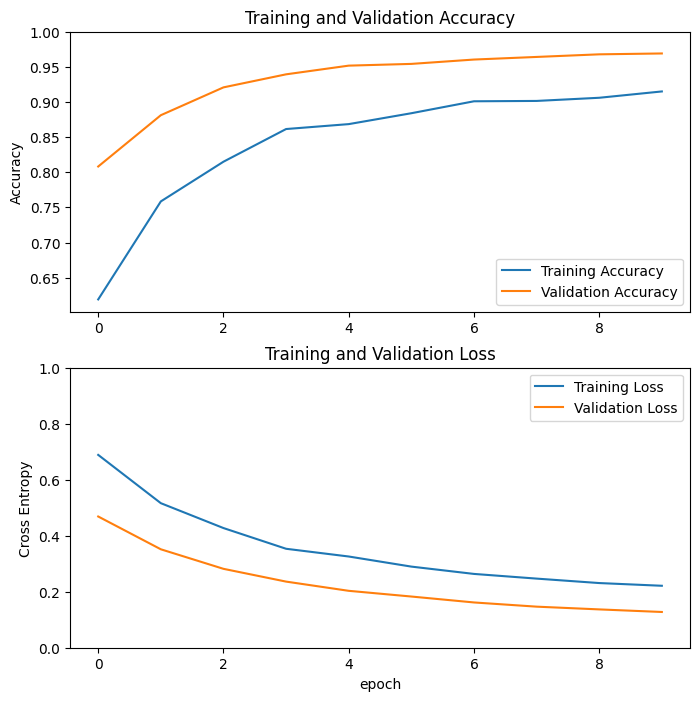

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<h1><font color='#4169E1'>II. Fine-tuning a pre-trained model</font></h1>

In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

<h3><font color='#D23B68'>Unfreeze the top layers of the model</font></h3>

All we need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [29]:
base_model.trainable = True

In [31]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


<h3><font color='#D23B68'>Compile the model</font></h3>

As we are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, our model could overfit very quickly.

In [32]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [34]:
# Oh boyy, we have a lot of training to do :) !

len(model.trainable_variables)

56

<h3><font color='#D23B68'>Continue training the model</font></h3>

If we trained to convergence earlier, this step will improve our accuracy by a few percentage points.

In [35]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 13s 85ms/step - loss: 0.1583 - accuracy: 0.9435 - val_loss: 0.0801 - val_accuracy: 0.9740
Epoch 11/20
63/63 [==============================] - 4s 57ms/step - loss: 0.1253 - accuracy: 0.9500 - val_loss: 0.0507 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 4s 64ms/step - loss: 0.1115 - accuracy: 0.9595 - val_loss: 0.0388 - val_accuracy: 0.9864
Epoch 13/20
63/63 [==============================] - 4s 57ms/step - loss: 0.0992 - accuracy: 0.9630 - val_loss: 0.0425 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 4s 58ms/step - loss: 0.0860 - accuracy: 0.9675 - val_loss: 0.0431 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 5s 69ms/step - loss: 0.0842 - accuracy: 0.9630 - val_loss: 0.0428 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 4s 62ms/step - loss: 0.0678 - accuracy: 0.9725 - val_loss: 0.0386 - val_accuracy: 0.9851
Epoch

<h3><font color='#D23B68'>Learning Curves</font></h3>

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

We may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.

After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

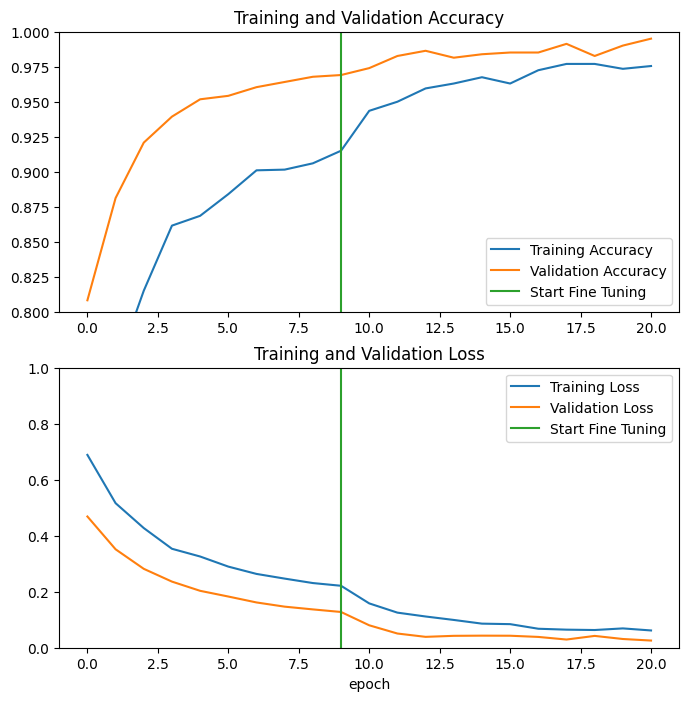

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<h3><font color='#D23B68'>Evaluation and prediction</font></h3>

Let's verify the performance of the model on new data using test set.

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 35ms/step - loss: 0.0191 - accuracy: 0.9948
Test accuracy : 0.9947916865348816


We're all set to use this model to predict if our cute pet is a cat or dog :)

Predictions:
 [0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1]
Labels:
 [0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1]


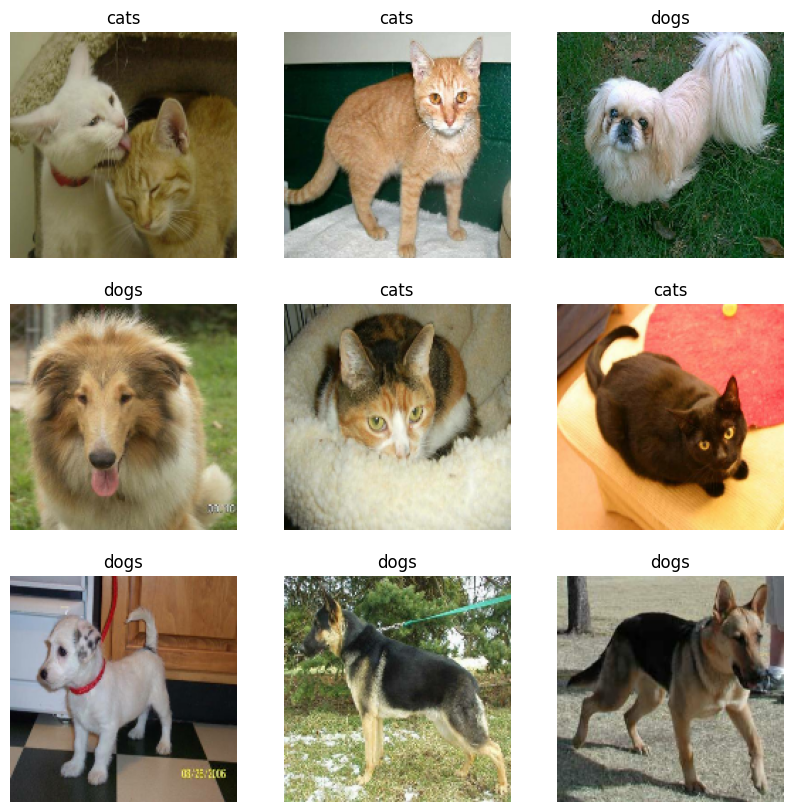

In [39]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

##### References : Tensorflow Tutorial Page ✨